In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

from keras.applications.resnet import ResNet50,preprocess_input

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/MyDrive/CSE547/project")

In [ ]:
train_images = np.load('train_images.npz')
val_images = np.load('val_images.npz')
test_images = np.load('test_images.npz')

In [ ]:
len(train_images.files)

29883

In [ ]:
train_images = [train_images[key] for key in train_images.files]
train_images = np.array(train_images)
train_images.shape

(29883, 65536)

In [ ]:
train_images=train_images.reshape(29883,256,256)

In [ ]:
val_images = [val_images[key] for key in val_images.files]
val_images = np.array(val_images)
val_images=val_images.reshape(6403,256,256)

In [ ]:
test_images = [test_images[key] for key in test_images.files]
test_images = np.array(test_images)
test_images=test_images.reshape(6407,256,256)

In [ ]:
train_labels = pd.read_csv('train_labels.csv')
val_labels = pd.read_csv('val_labels.csv')
test_labels = pd.read_csv('test_labels.csv')

In [ ]:
train_labels

,Unnamed: 0,class,case
0,5780,Astrocytoma,9
1,41892,Astrocytoma,62
2,50748,Astrocytoma,74
3,66607,Astrocytoma,97
4,33034,Astrocytoma,48
...,...,...,...
29878,49517,abnormality,72
29879,28827,abnormality,42
29880,21035,abnormality,30
29881,24907,abnormality,36


In [ ]:
train_labels['class'].value_counts()

class
Astrocytoma          9216
Glioblastoma         8658
Oligodendroglioma    6703
abnormality          5306
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
classes=train_labels['class']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(classes)
train_labels= to_categorical(integer_labels)

classes=val_labels['class']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(classes)
val_labels= to_categorical(integer_labels)

classes=test_labels['class']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(classes)
test_labels= to_categorical(integer_labels)

train_images=np.stack((train_images,) * 3, axis=-1)
val_images=np.stack((val_images,) * 3, axis=-1)
test_images=np.stack((test_images,) * 3, axis=-1)

In [ ]:
train_images = preprocess_input(train_images)
val_images= preprocess_input(val_images)
test_images=preprocess_input(test_images)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(29883, 4)
(6403, 4)
(6407, 4)
(29883, 256, 256, 3)
(6403, 256, 256, 3)
(6407, 256, 256, 3)


# Resnet Model Training

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("drive/MyDrive/CSE547/project/model_checkpoint1_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
# Transfer Learning using Resnet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))

model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Training
optimizer = Adam(learning_rate=0.00001)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
import time
start_time = time.time()
history=model.fit(train_images, train_labels, epochs=30, batch_size=8, validation_data=(val_images, val_labels), callbacks=[reduce_lr, checkpoint])
end_time = time.time()

Epoch 1/30
3736/3736 [==============================] - ETA: 0s - loss: 1.3964 - accuracy: 0.4176
Epoch 1: val_accuracy improved from -inf to 0.64360, saving model to drive/MyDrive/CSE547/project/model_checkpoint1_2.h5
3736/3736 [==============================] - 87s 21ms/step - loss: 1.3964 - accuracy: 0.4176 - val_loss: 0.9056 - val_accuracy: 0.6436 - lr: 1.0000e-05
Epoch 2/30
3735/3736 [============================>.] - ETA: 0s - loss: 0.9768 - accuracy: 0.5990
Epoch 2: val_accuracy improved from 0.64360 to 0.74137, saving model to drive/MyDrive/CSE547/project/model_checkpoint1_2.h5
3736/3736 [==============================] - 69s 18ms/step - loss: 0.9769 - accuracy: 0.5990 - val_loss: 0.6960 - val_accuracy: 0.7414 - lr: 1.0000e-05
Epoch 3/30
3734/3736 [============================>.] - ETA: 0s - loss: 0.7487 - accuracy: 0.7065
Epoch 3: val_accuracy improved from 0.74137 to 0.79931, saving model to drive/MyDrive/CSE547/project/model_checkpoint1_2.h5
3736/3736 [======================

# Train Results

In [ ]:
print("Training Time:", end_time - start_time)

Training Time: 2125.609542608261


In [ ]:
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
print("Train Accuracy", training_accuracy[-2])
print("Train Loss", training_loss[-2])

Train Accuracy 0.9662684202194214
Train Loss 0.11124289780855179


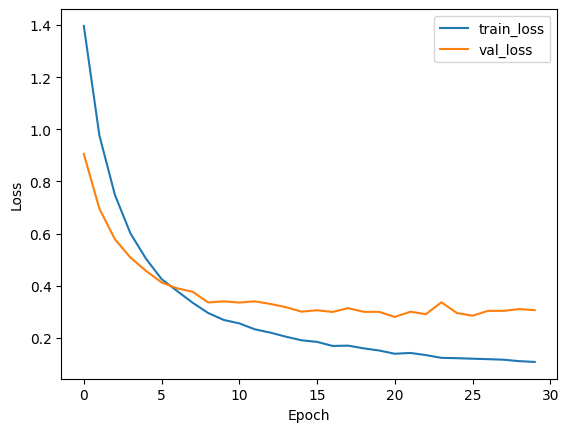

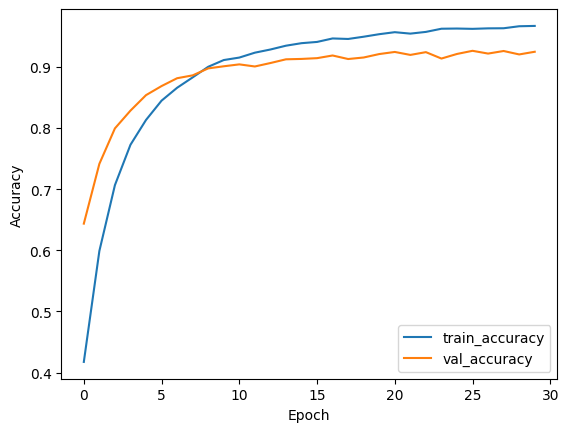

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test Results

In [ ]:
model.load_weights("drive/MyDrive/CSE547/project/model_checkpoint1_2.h5")

In [ ]:
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print("Validation Accuracy", val_accuracy)
print("Validation Loss", val_loss)

201/201 [==============================] - 7s 32ms/step - loss: 0.2855 - accuracy: 0.9261
Validation Accuracy 0.9261283874511719
Validation Loss 0.2855372130870819


In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Accuracy", test_accuracy)
print("Test Loss", test_loss)

201/201 [==============================] - 7s 34ms/step - loss: 0.2741 - accuracy: 0.9173
Test Accuracy 0.917277991771698
Test Loss 0.27408167719841003


# Evaluation

In [ ]:
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

201/201 [==============================] - 7s 28ms/step


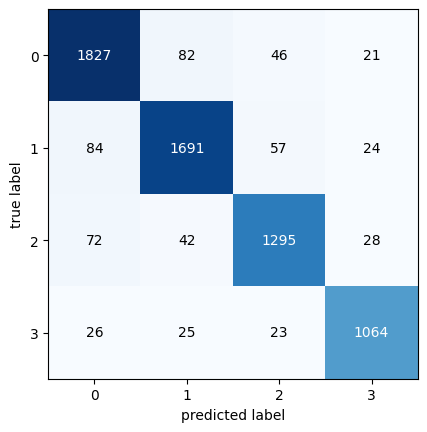

In [ ]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

fig, ax = plot_confusion_matrix(conf_mat=cm)

In [ ]:
from sklearn.metrics import precision_score, recall_score, fbeta_score

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f2_score = fbeta_score(true_labels, predicted_labels, beta=2, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F2 Score:", f2_score)

Precision: 0.9173109055106693
Recall: 0.9172779772124239
F2 Score: 0.9172648335484311


In [ ]:
class_labels = label_encoder.classes_

print("Class Labels:")
for i, label in enumerate(class_labels):
    print(f"Class {i}: {label}")

Class Labels:
Class 0: Astrocytoma
Class 1: Glioblastoma
Class 2: Oligodendroglioma
Class 3: abnormality


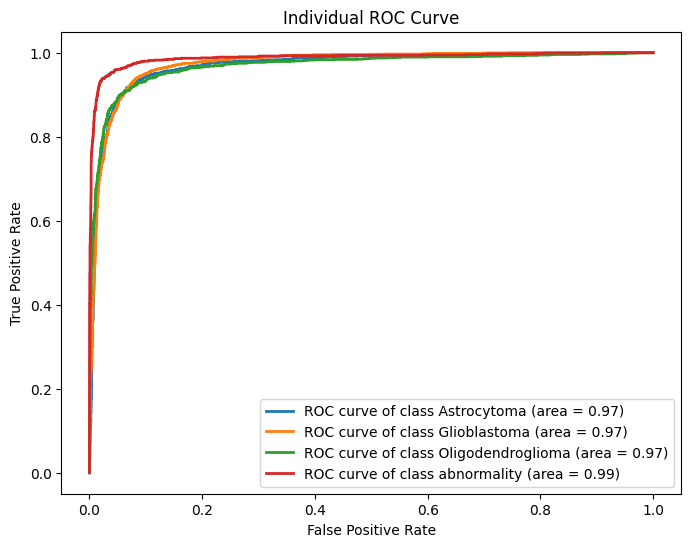

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class %s (area = %0.2f)' % (class_labels[i], roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Individual ROC Curve')
plt.legend(loc='lower right')
plt.show()

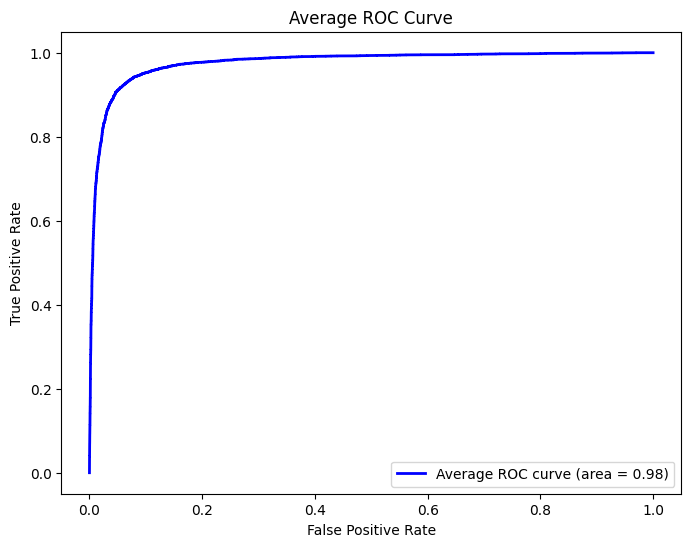

In [ ]:
fpr_avg, tpr_avg, _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc_avg = auc(fpr_avg, tpr_avg)

plt.figure(figsize=(8, 6))
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label='Average ROC curve (area = %0.2f)' % roc_auc_avg)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve')
plt.legend(loc='lower right')
plt.show()